In [2]:
# %% [code]
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
# from mne.connectivity import spectral_connectivity

print("MNE version:", mne.__version__)
print("MNE file location:", mne.__file__)


MNE version: 1.9.0
MNE file location: /Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/mne/__init__.py


In [3]:
# %% [code]
def explore_subject(subject_path):
    h5_files = list(subject_path.rglob("interictal_ieeg_processed.h5"))
    if not h5_files:
        print("No H5 file found in", subject_path)
        return
    h5_file = h5_files[0]
    print("File:", h5_file)
    with h5py.File(h5_file, 'r') as f:
        print("Top-level keys:", list(f.keys()))
        if 'bipolar_montage' in f:
            bm = f['bipolar_montage']
            print("bipolar_montage keys:", list(bm.keys()))
            if 'ieeg' in bm:
                ieeg = bm['ieeg']
                print("ieeg attributes:", dict(ieeg.attrs))
                print("ieeg shape:", ieeg.shape)
            if 'coordinates' in bm:
                coords = bm['coordinates']
                print("coordinates attributes:", dict(coords.attrs))
                print("coordinates shape:", coords.shape)

subject_path = Path("/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/Penn/sub-RID0238")
explore_subject(subject_path)


File: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/Penn/sub-RID0238/interictal_ieeg_processed.h5
Top-level keys: ['bipolar_montage']
bipolar_montage keys: ['coordinates', 'ieeg']
ieeg attributes: {'channels_labels': array(['LA01', 'LA02', 'LA03', 'LA04', 'LA05', 'LA06', 'LA07', 'LB01',
       'LB02', 'LB03', 'LB04', 'LB05', 'LB06', 'LB07', 'LC01', 'LC02',
       'LC03', 'LC04', 'LC05', 'LC06', 'LC07', 'LD01', 'LD02', 'LD03',
       'LD04', 'LD05', 'LD06', 'LE01', 'LE02', 'LE03', 'LF01', 'LF02',
       'LF03', 'LF04', 'LF05', 'LF06', 'LF07', 'LG01', 'LG02', 'LG03',
       'LG04', 'LG05', 'LG06', 'LG07', 'LH01', 'LH02', 'LH03', 'RA01',
       'RA02', 'RA03', 'RA04', 'RA05', 'RA06', 'RA07', 'RB01', 'RB02',
       'RB03', 'RB04', 'RB05', 'RB06', 'RB07', 'RC01', 'RC02', 'RC03',
       'RC04', 'RC05', 'RC06', 'RC07', 'RD01', 'RD02', 'RD03', 'RD04',
       'RD05', 'RD06', 'RE01', 'RE02', 'RE03', 'RE04', 'RE05', 'RE06',
       'RE07', 'RF01', 'RF02', 'RF03', 'RF04', 'R

In [4]:
# %% [code]
def load_ieeg_data(subject_path):
    h5_files = list(subject_path.rglob("interictal_ieeg_processed.h5"))
    if not h5_files:
        raise FileNotFoundError(f"No H5 file found in {subject_path}")
    h5_file = h5_files[0]
    with h5py.File(h5_file, 'r') as f:
        ieeg_data = f['/bipolar_montage/ieeg']
        bipolar_df = pd.DataFrame(ieeg_data, columns=ieeg_data.attrs['channels_labels'])
        fs = ieeg_data.attrs['sampling_rate']
    return bipolar_df, fs

bipolar_df, fs = load_ieeg_data(subject_path)
print("Loaded data shape:", bipolar_df.shape)
print("Sampling frequency:", fs)
data = bipolar_df.values


Loaded data shape: (1843200, 102)
Sampling frequency: 1024.0


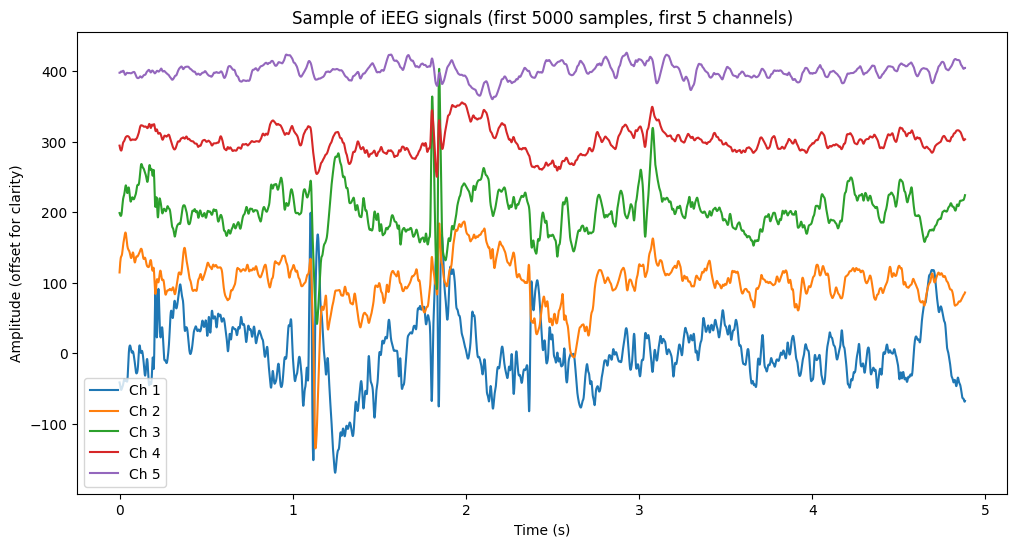

In [5]:
# %% [code]
# Plot a sample of the iEEG signals (first 5000 samples, first 5 channels)
time = np.arange(data.shape[0]) / fs
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(time[:5000], data[:5000, i] + 100*i, label=f'Ch {i+1}')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (offset for clarity)")
plt.title("Sample of iEEG signals (first 5000 samples, first 5 channels)")
plt.legend()
plt.show()


In [6]:
# %% [code]
# Create an MNE EpochsArray from the data using 2-second epochs.
def create_mne_epochs(data, fs, win_size=2):
    win_samples = int(win_size * fs)
    n_epochs = data.shape[0] // win_samples
    # Reshape each epoch as (n_channels, n_samples_per_epoch)
    segments = [data[i*win_samples:(i+1)*win_samples, :].T for i in range(n_epochs)]
    segments = np.array(segments)  # shape: (n_epochs, n_channels, win_samples)
    ch_names = bipolar_df.columns.tolist()
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)
    epochs = mne.EpochsArray(segments, info)
    return epochs

epochs = create_mne_epochs(data, fs, win_size=2)
print("Epochs shape:", epochs.get_data().shape)

Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Epochs shape: (900, 102, 2048)


In [ ]:
# %% [code]
# Compute frequency-domain connectivity using MNE's spectral_connectivity.
# We'll compute coherence and PLV in the 8-12 Hz (alpha) band.
methods = ['coh', 'plv']
fmin, fmax = 8.0, 12.0

con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    data=epochs,
    method=methods,
    sfreq=fs,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    tmin=None,
    tmax=None,
    mt_adaptive=False,
    n_jobs=-1
)
print("Connectivity output shape:", con.shape)
# Extract coherence and PLV matrices (shape: n_channels x n_channels)
coh_matrix = con[methods.index('coh')]
plv_matrix = con[methods.index('plv')]


In [ ]:
# %% [code]
# Plot the frequency-domain connectivity matrices computed by MNE
fc_names = ['Coherence (8-12Hz)', 'PLV (8-12Hz)']
fc_mats = [coh_matrix, plv_matrix]

plt.figure(figsize=(10, 5))
for i, (name, fc) in enumerate(zip(fc_names, fc_mats)):
    plt.subplot(1, 2, i+1)
    plt.imshow(fc, cmap='viridis', aspect='auto')
    plt.title(name)
    plt.colorbar()
plt.tight_layout()
plt.show()
